#Adapter Method#

In [ ]:
pip install transformers adapters datasets

#English adapter#

In [ ]:
import requests
import pandas as pd
from datasets import Dataset, DatasetDict


urls = {
    "train": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/eng/train-00000-of-00001.parquet",
    "validation": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/eng/dev-00000-of-00001.parquet",
    "test": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/eng/test-00000-of-00001.parquet"
}
import os
download_dir = "./brighter_emotion_data"
os.makedirs(download_dir, exist_ok=True)


dataset_dict = {}
for split, url in urls.items():
    file_path = os.path.join(download_dir, f"{split}.parquet")
    print(f"Downloading {split} data from {url} to {file_path}...")
    response = requests.get(url)
    response.raise_for_status()
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {split} data.")

    print(f"Loading {split} data into pandas DataFrame...")
    df = pd.read_parquet(file_path)
    print(f"Loaded {split} data.")

    if 'disgust' in df.columns:
            df['disgust'] = df['disgust'].replace('NaN', pd.NA)
            df['disgust'] = df['disgust'].fillna(0).astype(int)

    dataset_dict[split] = Dataset.from_pandas(df)
    print(f"Converted {split} data to Hugging Face Dataset.")

dataset = DatasetDict(dataset_dict)

print("\nDataset structure:")
print(dataset)

Downloaded train data.
Loading train data into pandas DataFrame...
Loaded train data.
Converted train data to Hugging Face Dataset.
Downloaded validation data.
Loading validation data into pandas DataFrame...
Loaded validation data.
Converted validation data to Hugging Face Dataset.
Downloaded test data.
Loading test data into pandas DataFrame...
Loaded test data.
Converted test data to Hugging Face Dataset.

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 2768
    })
    validation: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 232
    })
    test: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 5534
    })
})


In [ ]:
#identifying unique labels
unique_emotions = set()
for emotions_list in dataset["train"]["emotions"]:
    for emotion in emotions_list:
        unique_emotions.add(emotion)

unique_emotions = sorted(list(unique_emotions))
num_unique_emotions = len(unique_emotions)

print("Unique emotions:", unique_emotions)
print("Number of unique emotions:", num_unique_emotions)


label_to_id = {label: i for i, label in enumerate(unique_emotions)}
id_to_label = {i: label for label, i in label_to_id.items()}

print("Label to id mapping:", label_to_id)
print("Id to label mapping:", id_to_label)

Unique emotions: ['anger', 'fear', 'joy', 'sadness', 'surprise']
Number of unique emotions: 5
Label to id mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'surprise': 4}
Id to label mapping: {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise'}


In [89]:
from transformers import AutoTokenizer
from datasets import DatasetDict

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

unique_emotions = set()
if 'dataset' in locals() and isinstance(dataset, DatasetDict):
    for split in dataset:
        for emotions_list in dataset[split]["emotions"]:
            if isinstance(emotions_list, list):
                for emotion in emotions_list:
                    if isinstance(emotion, str):
                        unique_emotions.add(emotion)
            elif isinstance(emotions_list, str):
                 unique_emotions.add(emotions_list)

unique_emotions.add("disgust")
unique_emotions = sorted(list(unique_emotions))
num_labels = len(unique_emotions)

label_to_id = {label: i for i, label in enumerate(unique_emotions)}
id_to_label = {i: label for label, i in label_to_id.items()}

print("Unique emotions:", unique_emotions)
print("Number of unique emotions:", num_labels)
print("Label to id mapping:", label_to_id)
print("Id to label mapping:", id_to_label)

def tokenize_and_label(examples, num_labels=None, label_to_id=None):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding="max_length")
    # Creating multi-hot encoded labels
    batch_labels = []
    for emotion_list in examples["emotions"]:
        labels = [0.0] * num_labels
        if isinstance(emotion_list, list):
            for emotion in emotion_list:
                 if emotion in label_to_id:
                    labels[label_to_id[emotion]] = 1.0
        elif isinstance(emotion_list, str):
             if emotion_list in label_to_id:
                labels[label_to_id[emotion_list]] = 1.0
        batch_labels.append(labels)


    tokenized_inputs["labels"] = batch_labels
    return tokenized_inputs


tokenized_dataset = dataset.map(tokenize_and_label, batched=True, fn_kwargs={"num_labels": num_labels, "label_to_id": label_to_id})

columns_to_remove = ['id', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions', 'text']

tokenized_dataset = tokenized_dataset.remove_columns(columns_to_remove)

print("\nTokenized Dataset Structure:")
print(tokenized_dataset)

print("\nSample from Tokenized Dataset:")
print(tokenized_dataset["train"][0])

Unique emotions: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Number of unique emotions: 6
Label to id mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}
Id to label mapping: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}


Map:   0%|          | 0/2768 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]


Tokenized Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2768
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 232
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5534
    })
})

Sample from Tokenized Dataset:
{'input_ids': [101, 14136, 11272, 117, 20181, 10108, 11858, 57204, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from transformers import DataCollatorWithPadding
import torch


class CustomDataCollatorForMultiLabel(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)

        if "labels" in features[0]:
            batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.float32)

        return batch

data_collator = CustomDataCollatorForMultiLabel(tokenizer=tokenizer, return_tensors='pt')

In [91]:
# Training setup
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from transformers import TrainingArguments, Trainer
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)

    if labels.shape[0] == 0 or preds.shape[0] == 0 or labels.shape != preds.shape:
        print("Warning: Empty or shape-mismatched inputs for compute_metrics. Returning empty metrics.")
        return {}

    labels_flat = labels.flatten() if labels.ndim > 1 else labels
    preds_flat = preds.flatten() if preds.ndim > 1 else preds
    probs_flat = probs.flatten() if probs.ndim > 1 else probs


    if preds_flat.sum() == 0 and labels_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 1.0
    elif preds_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 0.0
    else:
        f1_micro = f1_score(labels_flat, preds_flat, average='micro', zero_division=0)
        f1_macro = f1_score(labels_flat, preds_flat, average='macro', zero_division=0)
        f1_weighted = f1_score(labels_flat, preds_flat, average='weighted', zero_division=0)

    try:
         roc_auc = roc_auc_score(labels, probs, average="weighted")
    except ValueError as e:
        print(f"Warning: Could not compute ROC AUC score. {e}")
        roc_auc = float('nan')
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy_score(labels_flat, preds_flat),
        'roc_auc': roc_auc,
    }

In [92]:
from transformers import AutoTokenizer, AutoConfig
from adapters import AutoAdapterModel, AdapterConfig
import torch.nn as nn
import os

num_labels = 6
print(f"Expecting model to output shape [batch_size, {num_labels}]")


model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
model = AutoAdapterModel.from_pretrained(model_name, config=config)

# adapter setup
english_adapter_name = "english_emotion"
adapter_config = AdapterConfig.load(
    "pfeiffer",
    reduction_factor=16,
    original_ln_before=True,
    original_ln_after=True,
    residual_before_ln=True
)

model.add_adapter(english_adapter_name, config=adapter_config)

model.add_classification_head(
    english_adapter_name,
    num_labels=num_labels,
    layers=1,
    use_pooler=True
)


import os


save_directory = "./saved_adapters/english_emotion"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
model.save_adapter(save_directory, english_adapter_name)

loaded_model = AutoAdapterModel.from_pretrained(model_name)
loaded_model.load_adapter(save_directory)

loaded_model.set_active_adapters(english_adapter_name)


dummy_input = tokenizer("Sample text", return_tensors="pt")
outputs = model(**dummy_input)
print(f"Model output shape: {outputs.logits.shape}")

class FixedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if logits.dim() != 2 or logits.shape[1] != num_labels:
            raise ValueError(
                f"Invalid logits shape: {logits.shape}. "
                f"Expected [batch_size, {num_labels}]. "
                "Check your classification head configuration."
            )
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

save_directory = "./saved_adapters/english_emotion"

if os.path.exists(save_directory):
    model.load_adapter(save_directory)
else:
    raise FileNotFoundError(f"Adapter directory not found at {save_directory}. Please ensure the adapter was saved correctly.")

model.set_active_adapters(english_adapter_name)
model.train_adapter(english_adapter_name)

#Training setup
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=8,
    learning_rate=3e-4,
    num_train_epochs=1,
    remove_unused_columns=False
)

trainer = FixedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

Expecting model to output shape [batch_size, 6]


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model output shape: torch.Size([1, 6])


In [93]:
print(model.adapters_config.adapters)

{'english_emotion': '9076f36a74755ac4'}


In [94]:
model.set_active_adapters("english_emotion")

In [95]:
#Training the adapter
trainer.train()
#trainer.evaluate()

Step,Training Loss


TrainOutput(global_step=346, training_loss=0.4695058392651508, metrics={'train_runtime': 193.8499, 'train_samples_per_second': 14.279, 'train_steps_per_second': 1.785, 'total_flos': 741975576920064.0, 'train_loss': 0.4695058392651508, 'epoch': 1.0})

In [96]:
def predict_emotion(text, adapter_name=english_adapter_name, threshold=0.3):
    model.set_active_adapters(adapter_name)
    model.eval()

    print(f"\nActive adapter check:", model.active_adapters)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, adapter_names=[adapter_name])

    probs = torch.sigmoid(outputs.logits).squeeze()
    print("Raw probabilities:", probs)

    if probs.dim() == 0:
        probs = probs.unsqueeze(0)

    preds = (probs > threshold).int().tolist()
    emotions = [id_to_label[i] for i, p in enumerate(preds) if p == 1]

    return emotions, {id_to_label[i]: float(probs[i]) for i in range(len(probs))}

try:
    english_text = "i am happy that it is sunny today!"
    print("\nTesting with text:", english_text)

    emotions, probs = predict_emotion(english_text)
    print("\nFinal Results:")
    print("Predicted emotions:", emotions)
    print("Probabilities:")
    for emotion, prob in probs.items():
        print(f"{emotion}: {prob:.4f}")
except Exception as e:
    print(f"Prediction failed: {str(e)}")




Testing with text: i am happy that it is sunny today!

Active adapter check: Stack[english_emotion]
Raw probabilities: tensor([0.1554, 0.0186, 0.3937, 0.4152, 0.2377, 0.3680], device='cuda:0')

Final Results:
Predicted emotions: ['fear', 'joy', 'surprise']
Probabilities:
anger: 0.1554
disgust: 0.0186
fear: 0.3937
joy: 0.4152
sadness: 0.2377
surprise: 0.3680


#Zulu adapter#

In [70]:
import requests
import pandas as pd
from datasets import Dataset, DatasetDict

urls = {
    "validation": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/zul/dev-00000-of-00001.parquet",
    "test": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/zul/test-00000-of-00001.parquet"
}

import os
download_dir = "./brighter_emotion_data"
os.makedirs(download_dir, exist_ok=True)

dataset_dict = {}
for split, url in urls.items():
    file_path = os.path.join(download_dir, f"{split}.parquet")
    print(f"Downloading {split} data from {url} to {file_path}...")
    response = requests.get(url)
    response.raise_for_status()
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {split} data.")


    print(f"Loading {split} data into pandas DataFrame...")
    df = pd.read_parquet(file_path)
    print(f"Loaded {split} data.")

    if 'disgust' in df.columns:
            df['disgust'] = df['disgust'].replace('NaN', pd.NA)
            df['disgust'] = df['disgust'].fillna(0).astype(int)

    dataset_dict[split] = Dataset.from_pandas(df)
    print(f"Converted {split} data to Hugging Face Dataset.")

zulu_dataset = DatasetDict(dataset_dict)

print("\nDataset structure:")
print(zulu_dataset)

Downloaded validation data.
Loading validation data into pandas DataFrame...
Loaded validation data.
Converted validation data to Hugging Face Dataset.
Downloaded test data.
Loading test data into pandas DataFrame...
Loaded test data.
Converted test data to Hugging Face Dataset.

Dataset structure:
DatasetDict({
    validation: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 875
    })
    test: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 2047
    })
})


In [ ]:
# Processing the Zulu dataset
def tokenize_and_label_zulu(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


    labels = [0.0] * len(label_to_id)
    if isinstance(examples["emotions"], list):
        for emotion in examples["emotions"]:
            if emotion in label_to_id:
                labels[label_to_id[emotion]] = 1.0
    tokenized["labels"] = labels

    return tokenized

tokenized_zulu = zulu_dataset.map(tokenize_and_label_zulu, batched=False)

columns_to_remove = ['id', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions', 'text']
tokenized_zulu = tokenized_zulu.remove_columns(columns_to_remove)

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

In [ ]:

unique_emotions = set()
for emotions_list in zulu_dataset["validation"]["emotions"]:
    for emotion in emotions_list:
        unique_emotions.add(emotion)

unique_emotions = sorted(list(unique_emotions))
num_unique_emotions = len(unique_emotions)
print("Unique emotions:", unique_emotions)
print("Number of unique emotions:", num_unique_emotions)

label_to_id = {label: i for i, label in enumerate(unique_emotions)}
id_to_label = {i: label for label, i in label_to_id.items()}

print("Label to id mapping:", label_to_id)
print("Id to label mapping:", id_to_label)

from transformers import AutoTokenizer, AutoConfig

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_label(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding="max_length")

    batch_labels = []
    for emotion_list in examples["emotions"]:
        labels = [0.0] * len(unique_emotions)
        if isinstance(emotion_list, list):
            for emotion in emotion_list:
                if emotion in label_to_id:
                    labels[label_to_id[emotion]] = 1.0
        elif isinstance(emotion_list, str):
            if emotion_list in label_to_id:
                labels[label_to_id[emotion_list]] = 1.0
        batch_labels.append(labels)

    tokenized_inputs["labels"] = batch_labels
    return tokenized_inputs

tokenized_zulu = zulu_dataset.map(tokenize_and_label, batched=True)

columns_to_remove = ['id', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions', 'text']
tokenized_zulu = tokenized_zulu.remove_columns(columns_to_remove)

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import torch.nn as nn
from adapters import AutoAdapterModel, AdapterConfig

class ZuluDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        if "labels" in features[0]:
            batch["labels"] = torch.tensor(
                [f["labels"] for f in features],
                dtype=torch.float32
            )
        return batch

data_collator = ZuluDataCollator(tokenizer=tokenizer)

# Model setup
num_labels = len(unique_emotions)
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
model = AutoAdapterModel.from_pretrained(model_name, config=config)

Zuluadapter_name = "zulu_emotion"
adapter_config = AdapterConfig.load(
    "pfeiffer",
    reduction_factor=16,
    original_ln_before=True,
    original_ln_after=True,
    residual_before_ln=True
)


model.add_adapter(Zuluadapter_name, config=adapter_config)
model.add_classification_head(
    Zuluadapter_name,
    num_labels=num_labels,
    layers=1,
    use_pooler=True
)

Unique emotions: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Number of unique emotions: 6
Label to id mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}
Id to label mapping: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}


Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from transformers import Trainer
import torch
import torch.nn as nn

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    preds = (probs > 0.5).astype(int)

    if labels.shape[0] == 0 or preds.shape[0] == 0 or labels.shape != preds.shape:
        print("Warning: Empty or shape-mismatched inputs for compute_metrics. Returning empty metrics.")
        return {}
    labels_flat = labels.flatten() if labels.ndim > 1 else labels
    preds_flat = preds.flatten() if preds.ndim > 1 else preds
    probs_flat = probs.flatten() if probs.ndim > 1 else probs


    if preds_flat.sum() == 0 and labels_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 1.0
    elif preds_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 0.0
    else:
        f1_micro = f1_score(labels_flat, preds_flat, average='micro', zero_division=0)
        f1_macro = f1_score(labels_flat, preds_flat, average='macro', zero_division=0)
        f1_weighted = f1_score(labels_flat, preds_flat, average='weighted', zero_division=0)

    try:
         roc_auc = roc_auc_score(labels, probs, average="weighted")
    except ValueError as e:
        print(f"Warning: Could not compute ROC AUC score. {e}")
        roc_auc = float('nan')

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy_score(labels_flat, preds_flat),
        'roc_auc': roc_auc,
    }



class ZuluTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if logits.shape != labels.shape:
             raise ValueError(
                 f"Shape mismatch between logits and labels in compute_loss: {logits.shape} vs {labels.shape}. "
                 f"Ensure data loading and batching provide matching shapes."
             )

        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        labels = inputs.pop("labels", None)

        with torch.no_grad():
            inputs_for_model = {k: v for k, v in inputs.items() if k != 'labels'}
            outputs = model(**inputs_for_model)
            logits = outputs.logits

        if labels is not None:
            if labels.shape[0] != logits.shape[0]:
                print(f"Adjusting labels batch size in prediction_step: {labels.shape[0]} -> {logits.shape[0]}")
                labels = labels[:logits.shape[0]]

            if prediction_loss_only:
                 loss_fct = nn.BCEWithLogitsLoss()
                 try:
                     loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1).float())
                 except RuntimeError as e:
                     print(f"RuntimeError during loss calculation in prediction_step: {e}")
                     loss = torch.tensor(float('nan'), device=logits.device)
                 logits = None
            else:
                loss = None
        else:
             loss = None

        return (loss, logits, labels)

In [74]:

save_directory = "./saved_adapters/zulu_emotion"

if os.path.exists(save_directory):
    try:
        model.load_adapter(save_directory, load_as=Zuluadapter_name)
        print(f"Loaded adapter '{Zuluadapter_name}' from {save_directory}")
    except Exception as e:
        print(f"Error loading adapter: {e}")
else:
    print(f"Adapter directory not found at {save_directory}. Adapter will be added and trained.")


print(model.adapters_config.adapters)
model.set_active_adapters(Zuluadapter_name)

can_enable = True
for layer in model.base_model.modules():
    if hasattr(layer, 'enable_adapters') and callable(getattr(layer, 'enable_adapters')):
        pass
    elif isinstance(layer, nn.ModuleList):
        pass
    elif isinstance(layer, nn.Sequential):
        pass
    elif isinstance(layer, nn.ModuleDict):
        pass
    elif not list(layer.children()):
         can_enable = False
         print(f"Layer {type(layer).__name__} does not have 'enable_adapters' method.")
         break


if can_enable:
    model.train_adapter(Zuluadapter_name)
else:
    print("Cannot train adapter due to incompatible layers. Skipping train_adapter call.")


training_args = TrainingArguments(
    output_dir="./zulu_adapter_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./zulu_logs',
    remove_unused_columns=False
)

trainer = ZuluTrainer(
     model=model,
     args=training_args,
     train_dataset=tokenized_zulu["validation"],
     eval_dataset=tokenized_zulu["test"],
     compute_metrics=compute_metrics,
     data_collator=data_collator
 )

Adapter directory not found at ./saved_adapters/zulu_emotion. Adapter will be added and trained.
{'zulu_emotion': '9076f36a74755ac4'}
Layer Embedding does not have 'enable_adapters' method.
Cannot train adapter due to incompatible layers. Skipping train_adapter call.


In [75]:
#Train the adapter
print(model.adapters_config.adapters)
model.set_active_adapters(Zuluadapter_name)
trainer.train()
trainer.evaluate()


try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.set_active_adapters(Zuluadapter_name)
    model.active_head = Zuluadapter_name

    zulu_text = "ngiphatheke kabi ukuthi umama wami ushonile"
    print("\nTesting with text:", zulu_text)

    emotions, probs = predict_emotion(zulu_text, adapter_name="zulu_emotion")


    print("\nFinal Results:")
    print("Predicted emotions:", emotions)
    print("Probabilities:")
    for emotion, prob in probs.items():
        print(f"{emotion}: {prob:.4f}")
except Exception as e:
    print(f"Prediction failed: {str(e)}")

{'zulu_emotion': '9076f36a74755ac4'}


Step,Training Loss



Testing with text: ngiphatheke kabi ukuthi umama wami ushonile

Active adapter check: Stack[zulu_emotion]
Raw probabilities: tensor([0.0819, 0.0293, 0.0310, 0.0565, 0.1894, 0.0903], device='cuda:0')

Final Results:
Predicted emotions: []
Probabilities:
anger: 0.0819
disgust: 0.0293
fear: 0.0310
joy: 0.0565
sadness: 0.1894
surprise: 0.0903


#Pidgin english adapter#

In [58]:

import os
import requests
import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoConfig,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer
)
from adapters import AutoAdapterModel, AdapterConfig
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np
from transformers.trainer_utils import EvalPrediction, PredictionOutput


urls = {
    "train": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/pcm/train-00000-of-00001.parquet",
    "validation": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/pcm/dev-00000-of-00001.parquet",
    "test": "https://huggingface.co/datasets/brighter-dataset/BRIGHTER-emotion-categories/resolve/main/pcm/test-00000-of-00001.parquet"
}

download_dir = "./brighter_emotion_data_pcm"
os.makedirs(download_dir, exist_ok=True)

pcm_dataset_dict = {}
for split, url in urls.items():
    file_path = os.path.join(download_dir, f"{split}.parquet")
    if not os.path.exists(file_path):
        print(f"Downloading {split} dataset...")
        response = requests.get(url)
        response.raise_for_status()
        with open(file_path, 'wb') as f:
            f.write(response.content)
    else:
        print(f"{split} dataset already exists. Skipping download.")
    df = pd.read_parquet(file_path)
    if 'disgust' in df.columns:
        df['disgust'] = df['disgust'].replace('NaN', pd.NA).fillna(0).astype(int)
    pcm_dataset_dict[split] = Dataset.from_pandas(df)

pcm_dataset = DatasetDict(pcm_dataset_dict)

if 'unique_emotions' not in globals() or 'label_to_id' not in globals():
    unique_emotions = set()
    for split in pcm_dataset:
        for emotions_list in pcm_dataset[split]["emotions"]:
            if isinstance(emotions_list, list):
                unique_emotions.update(emotions_list)
            elif isinstance(emotions_list, str):
                unique_emotions.add(emotions_list)

    unique_emotions = sorted(list(unique_emotions))
    label_to_id = {label: i for i, label in enumerate(unique_emotions)}
    id_to_label = {i: label for i, label in enumerate(unique_emotions)}
    num_labels = len(unique_emotions)
    print(f"Number of unique emotions for PCM: {num_labels}")
else:
    print("Unique emotions and label mappings already defined.")


model_name = "bert-base-multilingual-cased"
if 'tokenizer' not in globals():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("Tokenizer loaded.")
else:
    print("Tokenizer already exists.")


def tokenize_and_label(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=False)
    batch_labels = []
    for emotion_list in examples["emotions"]:
        labels = [0.0] * len(unique_emotions)
        if isinstance(emotion_list, list):
            for emotion in emotion_list:
                if emotion in label_to_id:
                    labels[label_to_id[emotion]] = 1.0
        elif isinstance(emotion_list, str) and emotion_list in label_to_id:
            labels[label_to_id[emotion_list]] = 1.0
        batch_labels.append(labels)
    tokenized["labels"] = batch_labels
    return tokenized

tokenized_pcm = pcm_dataset.map(tokenize_and_label, batched=True)
tokenized_pcm = tokenized_pcm.remove_columns(
    ['id', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions', 'text']
)


if 'data_collator' not in globals():
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    print("Data collator created.")
else:
    print("Data collator already exists.")



if 'model' not in globals():
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id
    )
    model = AutoAdapterModel.from_pretrained(model_name, config=config)
    print("Model loaded.")
else:
    print("Model already exists.")

PCMadapter_name = "pcm_emotion"
adapter_config = AdapterConfig.load(
    "pfeiffer",
    reduction_factor=16,
    original_ln_before=True,
    original_ln_after=True,
    residual_before_ln=True
)

if PCMadapter_name not in model.adapters_config.adapters:
    model.add_adapter(PCMadapter_name , config=adapter_config)
    model.add_classification_head(
        PCMadapter_name ,
        num_labels=num_labels,
        layers=1,
        use_pooler=True
    )
    print(f"Added adapter '{PCMadapter_name}' and classification head.")
else:
     print(f"Adapter '{PCMadapter_name}' already exists.")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)

    if labels.shape[0] == 0 or preds.shape[0] == 0 or labels.shape != preds.shape:
        print("Warning: Empty or shape-mismatched inputs for compute_metrics. Returning empty metrics.")
        return {}

    labels_flat = labels.flatten() if labels.ndim > 1 else labels
    preds_flat = preds.flatten() if preds.ndim > 1 else preds
    probs_flat = probs.flatten() if probs.ndim > 1 else probs


    if preds_flat.sum() == 0 and labels_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 1.0
    elif preds_flat.sum() == 0:
        f1_micro = f1_macro = f1_weighted = 0.0
    else:
        f1_micro = f1_score(labels_flat, preds_flat, average='micro', zero_division=0)
        f1_macro = f1_score(labels_flat, preds_flat, average='macro', zero_division=0)
        f1_weighted = f1_score(labels_flat, preds_flat, average='weighted', zero_division=0)

    try:
         roc_auc = roc_auc_score(labels, probs, average="weighted")
    except ValueError as e:
        print(f"Warning: Could not compute ROC AUC score. {e}")
        roc_auc = float('nan')

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy_score(labels_flat, preds_flat),
        'roc_auc': roc_auc,
    }

save_directory = "./saved_adapters/pcm_emotion"

if os.path.exists(save_directory):
    try:
        model.load_adapter(save_directory, load_as=PCMadapter_name)
        print(f"Loaded adapter '{PCMadapter_name}' from {save_directory}")
    except Exception as e:
        print(f"Error loading adapter: {e}")
else:
    print(f"Adapter directory not found at {save_directory}. Adapter will be added and trained.")

print(model.adapters_config.adapters)
model.set_active_adapters(PCMadapter_name)

for param in model.parameters():
    param.requires_grad = False


for name, param in model.named_parameters():
    if PCMadapter_name in name or "classification_head" in name:
        param.requires_grad = True

print("Parameters with requires_grad=True after unfreezing for PCM:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

#Training setup
training_args = TrainingArguments(
    output_dir="./pcm_adapter_output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-4,
    num_train_epochs=1,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./pcm_logs',
)


trainer = ZuluTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_pcm["train"],
    eval_dataset=tokenized_pcm["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

train dataset already exists. Skipping download.
validation dataset already exists. Skipping download.
test dataset already exists. Skipping download.
Unique emotions and label mappings already defined.
Tokenizer already exists.


Map:   0%|          | 0/3728 [00:00<?, ? examples/s]

Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/3740 [00:00<?, ? examples/s]

Data collator already exists.
Model already exists.
Adapter 'pcm_emotion' already exists.
Adapter directory not found at ./saved_adapters/pcm_emotion. Adapter will be added and trained.
{'english_emotion': '9076f36a74755ac4', 'pcm_emotion': '9076f36a74755ac4'}
Parameters with requires_grad=True after unfreezing for PCM:
bert.encoder.layer.0.output.adapters.pcm_emotion.adapter_down.0.weight
bert.encoder.layer.0.output.adapters.pcm_emotion.adapter_down.0.bias
bert.encoder.layer.0.output.adapters.pcm_emotion.adapter_up.weight
bert.encoder.layer.0.output.adapters.pcm_emotion.adapter_up.bias
bert.encoder.layer.1.output.adapters.pcm_emotion.adapter_down.0.weight
bert.encoder.layer.1.output.adapters.pcm_emotion.adapter_down.0.bias
bert.encoder.layer.1.output.adapters.pcm_emotion.adapter_up.weight
bert.encoder.layer.1.output.adapters.pcm_emotion.adapter_up.bias
bert.encoder.layer.2.output.adapters.pcm_emotion.adapter_down.0.weight
bert.encoder.layer.2.output.adapters.pcm_emotion.adapter_down.0

In [59]:
 print(model.adapters_config.adapters)
 model.set_active_adapters("pcm_emotion")
 trainer.train()
 trainer.evaluate()

 try:
    pidgin_text = "I dey happy well well"
    print("\nTesting with text:", pidgin_text)

    emotions, probs = predict_emotion(pidgin_text, adapter_name="pcm_emotion")
    print("\nFinal Results:")
    print("Predicted emotions:", emotions)
    print("Probabilities:")
    for emotion, prob in probs.items():
        print(f"{emotion}: {prob:.4f}")
 except Exception as e:
    print(f"Prediction failed: {str(e)}")


{'english_emotion': '9076f36a74755ac4', 'pcm_emotion': '9076f36a74755ac4'}


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Accuracy,Roc Auc
1,No log,No log,0.804570,0.660565,0.779787,0.804570,0.711681



Testing with text: I dey happy well well

Active adapter check: Stack[pcm_emotion]
Raw probabilities: tensor([0.0213, 0.1215, 0.0850, 0.6806, 0.1687, 0.2831], device='cuda:0')

Final Results:
Predicted emotions: ['joy']
Probabilities:
anger: 0.0213
disgust: 0.1215
fear: 0.0850
joy: 0.6806
sadness: 0.1687
surprise: 0.2831


#Visualisation#

In [ ]:
# Visualization Setup for All Adapters
!pip install matplotlib shap bertviz transformers scikit-learn ipython
import matplotlib.pyplot as plt
import shap
from IPython.display import display
from bertviz import head_view, model_view

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Available adapters: {'zulu_emotion': '9076f36a74755ac4'}

Visualizations for zulu_emotion

Attention visualization for: 'ngiphatheke kabi ukuthi umama wami ushonile'


<IPython.core.display.Javascript object>

None


SHAP explanation for: 'ngiphatheke kabi ukuthi umama wami ushonile'
SHAP explanation failed: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


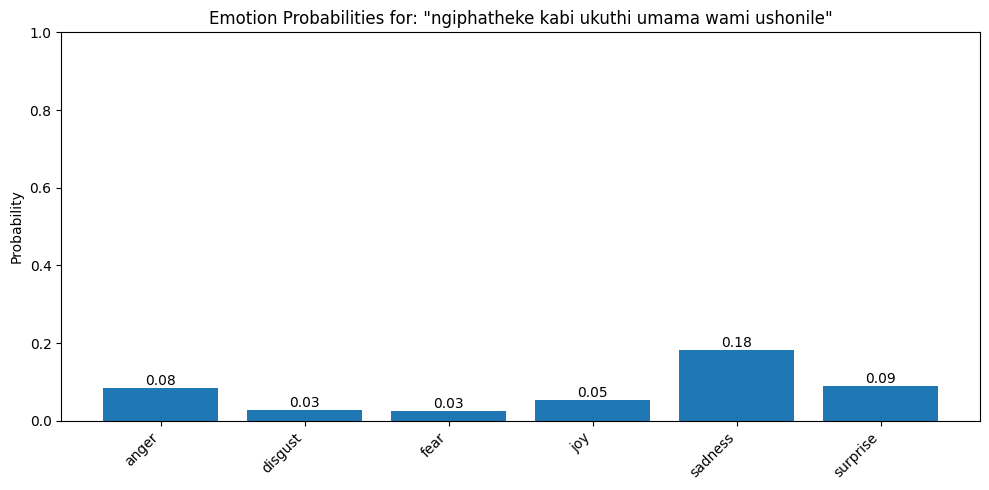

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from bertviz import head_view
import shap
from IPython.display import display
import torch
from transformers import AutoTokenizer

def check_and_set_adapter(model, adapter_name):
    """Safely activate adapter if available"""
    if adapter_name is None:
        model.set_active_adapters(None)
        return True

    available_adapters = model.adapters_config.adapters
    if adapter_name not in available_adapters:
        print(f"Warning: Adapter '{adapter_name}' not found. Available: {list(available_adapters.keys())}")
        return False

    model.set_active_adapters(adapter_name)
    model.active_head = adapter_name
    return True


def visualize_attention(model, tokenizer, text, adapter_name=None):
    """Show attention patterns"""
    if not check_and_set_adapter(model, adapter_name):
        return

    try:
        inputs = tokenizer(text, return_tensors='pt').to(model.device)
        outputs = model(**inputs, output_attentions=True)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        print(f"\nAttention visualization for: '{text}'")
        display(head_view(outputs.attentions, tokens))
    except Exception as e:
        print(f"Attention visualization failed: {str(e)}")

def explain_with_shap(model, tokenizer, text, adapter_name=None, max_length=128):
    """Explain predictions using SHAP"""
    if not check_and_set_adapter(model, adapter_name):
        return

    try:
        def predictor(texts):
            if isinstance(texts, str):
                texts = [texts]
            inputs = tokenizer(texts, return_tensors="pt", padding=True,
                             truncation=True, max_length=max_length).to(model.device)
            with torch.no_grad():
                outputs = model(**inputs)
            return torch.sigmoid(outputs.logits).cpu().numpy()

        print(f"\nSHAP explanation for: '{text}'")

        explainer = shap.Explainer(
            predictor,
            tokenizer,
            output_names=list(id_to_label.values())
        )

        shap_values = explainer([text])
        display(shap.plots.text(shap_values[0]))

        print("\nDetailed impacts:")
        for i, (token, value) in enumerate(zip(shap_values[0].data, shap_values[0].values)):
            print(f"{token:>15}: {value.sum():.3f} (total impact)")

    except Exception as e:
        print(f"SHAP explanation failed: {str(e)}")

def visualize_predictions(text, model, tokenizer, adapter_name=None):
    """Show emotion probability distribution"""
    if not check_and_set_adapter(model, adapter_name):
        return

    try:
        inputs = tokenizer(text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
        emotions = list(id_to_label.values())

        plt.figure(figsize=(10, 5))
        bars = plt.bar(emotions, probs)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Probability')
        plt.title(f'Emotion Probabilities for: "{text}"')
        plt.ylim(0, 1)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Prediction visualization failed: {str(e)}")

def run_visualizations(text, model, tokenizer, adapter_name=None):
    """Execute all visualizations"""
    print("\n" + "="*60)
    print(f"Visualizations for {'base model' if adapter_name is None else adapter_name}")
    print("="*60)

    visualize_attention(model, tokenizer, text, adapter_name)
    explain_with_shap(model, tokenizer, text, adapter_name)
    visualize_predictions(text, model, tokenizer, adapter_name)

def plot_training_metrics(trainer):
    """Plot training history if available"""
    if not hasattr(trainer, 'state') or not trainer.state.log_history:
        print("No training metrics available")
        return

    history = trainer.state.log_history
    metrics = {
        'loss': [],
        'eval_loss': [],
        'eval_f1': [],
        'steps': []
    }

    for entry in history:
        for key in metrics:
            if key in entry:
                metrics[key].append(entry[key])

    plt.figure(figsize=(12, 5))
    plt.plot(metrics['steps'][:len(metrics['loss'])], metrics['loss'], label='Training Loss')
    if metrics['eval_loss']:
        plt.plot(metrics['steps'][:len(metrics['eval_loss'])], metrics['eval_loss'], label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    print("Available adapters:", model.adapters_config.adapters)

    examples = {
        "pcm_emotion": "I dey happy well well today!",
        "zulu_emotion": "ngiphatheke kabi ukuthi umama wami ushonile",
        "english_emotion": "I am happy it is warm outside today",
        "base_model": "I'm feeling happy today"
    }

    for adapter_name in model.adapters_config.adapters:
        run_visualizations(examples.get(adapter_name, examples["base_model"]),
                         model, tokenizer, adapter_name)

    if 'trainer' in locals():
        plot_training_metrics(trainer)

main()

#visu#

In [ ]:
def visualize_metrics(trainer, adapter_name):
    """Visualize training metrics including F1 scores"""
    if not hasattr(trainer, 'state') or not trainer.state.log_history:
        print("No training metrics available")
        return

    history = trainer.state.log_history
    steps = []
    f1_scores = {'micro': [], 'macro': [], 'weighted': []}

    for entry in history:
        if 'eval_f1_micro' in entry:
            steps.append(entry.get('step', 0))
            f1_scores['micro'].append(entry['eval_f1_micro'])
            f1_scores['macro'].append(entry['eval_f1_macro'])
            f1_scores['weighted'].append(entry['eval_f1_weighted'])

    if not steps:
        print("No evaluation metrics found in training history")
        return

    plt.figure(figsize=(10, 5))
    for metric, scores in f1_scores.items():
        plt.plot(steps, scores, label=f'F1 {metric}')

    plt.xlabel('Training Steps')
    plt.ylabel('Score')
    plt.title(f'Evaluation Metrics for {adapter_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_metrics = {k: v[-1] for k, v in f1_scores.items()}
    print(f"\nFinal F1 Scores for {adapter_name}:")
    for metric, score in final_metrics.items():
        print(f"{metric:>8}: {score:.4f}")


def plot_f1_scores(trainer, adapter_name):
    """Plot F1 scores from evaluation"""
    if not hasattr(trainer, 'state') or not trainer.state.log_history:
        print("No evaluation metrics available")
        return

    history = trainer.state.log_history
    eval_steps = []
    f1_micro = []
    f1_macro = []
    f1_weighted = []

    for entry in history:
        if 'eval_f1_micro' in entry:
            eval_steps.append(entry.get('step', 0))
            f1_micro.append(entry['eval_f1_micro'])
            f1_macro.append(entry['eval_f1_macro'])
            f1_weighted.append(entry['eval_f1_weighted'])

    if not eval_steps:
        print("No F1 scores found in training history")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(eval_steps, f1_micro, label='Micro F1')
    plt.plot(eval_steps, f1_macro, label='Macro F1')
    plt.plot(eval_steps, f1_weighted, label='Weighted F1')
    plt.xlabel('Steps')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Scores for {adapter_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_predictions(text, model, tokenizer, adapter_name=None):
    """Show emotion probability distribution"""
    if not check_and_set_adapter(model, adapter_name):
        return

    try:
        inputs = tokenizer(text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
        emotions = list(id_to_label.values())

        plt.figure(figsize=(10, 5))
        bars = plt.bar(range(len(emotions)), probs)
        plt.xticks(range(len(emotions)), emotions, rotation=45, ha='right')
        plt.ylabel('Probability')
        plt.title(f'Emotion Probabilities for: "{text}"')
        plt.ylim(0, 1)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Prediction visualization failed: {str(e)}")

def main():
    """Example usage with your model"""
    print("Available adapters:", model.adapters_config.adapters)

    examples = {
        "zulu_emotion": "ngiphatheke kabi ukuthi umama wami ushonile",
    }

    for adapter_name in model.adapters_config.adapters:
        print(f"\n=== Visualizations for {adapter_name} ===")
        example_text = examples.get(adapter_name, "I'm feeling happy today")

        visualize_predictions(example_text, model, tokenizer, adapter_name)
        explain_with_shap(model, tokenizer, example_text, adapter_name)

        if 'trainer' in locals():
            visualize_metrics(trainer, adapter_name)

Available adapters: {'english_emotion': '9076f36a74755ac4'}

=== Visualizations for english_emotion ===


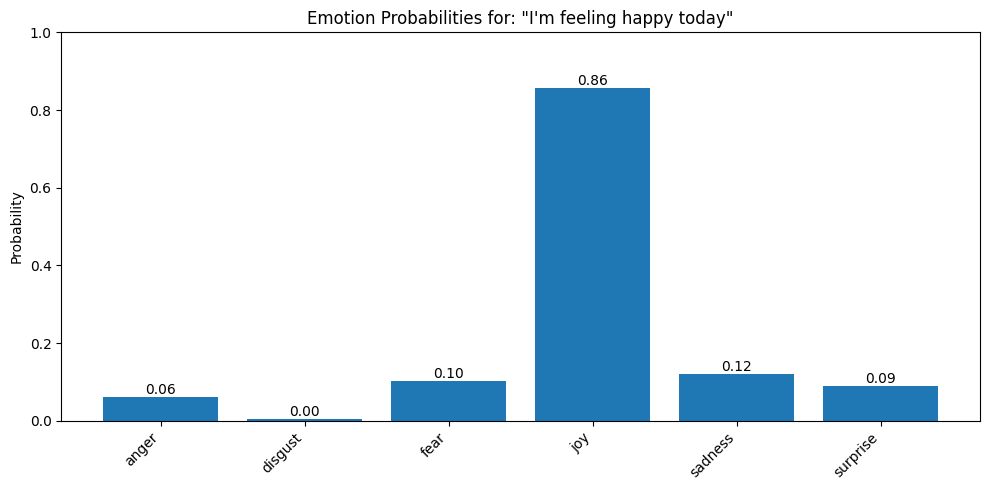


SHAP explanation for: 'I'm feeling happy today'
SHAP explanation failed: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [ ]:
main()